# Time Series Forecasting

## Setup

In [1]:
from google.colab import drive

drive.mount("./gdrive", force_remount=True)
%cd "./gdrive/My Drive/Colab Notebooks/sampco"

Mounted at ./gdrive
/content/gdrive/My Drive/Colab Notebooks/sampco


In [3]:
!pip install hampel statsmodels -q -U

     |████████████████████████████████| 9.5MB 8.1MB/s 


In [4]:
from hampel import hampel

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
import pandas as pd
import numpy as np
import datetime as dt

mpl.rcParams["font.size"] = 12
mpl.rcParams["axes.grid"] = False
mpl.rcParams["figure.figsize"] = (14, 7)

## Dataset

In [310]:
columns = [
    # "_CustomerKey",
    # "_PayerKey",
    # "_ShipToKey",
    # "_SoldToKey",
    # "_MaterialKey",
    "_CalendarKey",
    "TransactionType",
    # "Company",
    # "DocumentType",
    # "SalesChannel",
    # "SalesRepresentative",
    "SoldVolume",
    # "CasesSold",
    "VolumeUnit",
    "Revenue",
    # "Cogs",
    # "FreightRevenue",
    # # "FreightCost",
    # "Commission",
    # "Allowance",
    # "Discount",
    # "NetRevenue",
    # "GrossMargin",
]

df = pd.read_csv("FactSales.csv", parse_dates=["_CalendarKey"], usecols=columns)

## Preprocessing Data

In [311]:
df = df[(df["TransactionType"] == "SALES") & (df["SoldVolume"] > 0)]
df.loc[df["VolumeUnit"] == "KG", "SoldVolume"] = df["SoldVolume"].apply(lambda x: x * 2.2046)

df.drop(["TransactionType", "VolumeUnit"], axis=1, inplace=True)

In [312]:
df1 = df.groupby(["_CalendarKey"]).size().reset_index(name="Sales")
df2 = df.groupby(by=["_CalendarKey"], as_index=False)[df.drop("_CalendarKey", axis=1).columns].sum()
df = pd.merge(df1, df2, how="left", on=["_CalendarKey"])

df.sort_values(by=["_CalendarKey"], ascending=True, ignore_index=True, inplace=True)
df.set_index("_CalendarKey", inplace=True)

In [313]:
day = (24 * 60 * 60)
month = day * (30.4167)
year = day * (365.2425)

timestamp_s = df.index.map(dt.datetime.timestamp)

df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))
df["Month sin"] = np.sin(timestamp_s * (2 * np.pi / month))
df["Month cos"] = np.cos(timestamp_s * (2 * np.pi / month))

In [314]:
for col in df.columns:
    non_imp = hampel(df[col], window_size=30, n=3, imputation=False)
    df[col] = hampel(df[col], window_size=30, n=3, imputation=True).values    

    if non_imp:
        print(col, "->", non_imp)

Sales -> [187, 207, 228, 276, 337, 365, 366, 396, 415, 445, 558, 570, 666]
SoldVolume -> [45, 114, 174, 276, 318, 337, 340, 357, 366, 395, 396, 420, 445, 475, 524, 544]
Revenue -> [114, 276, 318, 337, 340, 357, 365, 366, 395, 396, 430, 445, 544, 570, 575, 598, 630, 649]


## Analysis

In [315]:
df

,Sales,SoldVolume,Revenue,Year sin,Year cos,Month sin,Month cos
_CalendarKey,,,,,,,
2018-12-31,20.0,55681.690208,138093.28,-0.015181,0.999885,0.766497,-0.642248
2019-01-02,18.0,119117.100000,318997.77,0.019223,0.999815,0.444153,-0.895951
2019-01-03,43.0,232366.558640,586796.37,0.036419,0.999337,0.250947,-0.968001
2019-01-04,100.0,426322.966275,1146033.81,0.053604,0.998562,0.047070,-0.998892
2019-01-07,15.0,77328.761242,274216.19,0.105044,0.994468,-0.541839,-0.840483
...,...,...,...,...,...,...,...
2021-04-28,21.0,66919.500000,177102.80,0.899222,-0.437493,0.989305,-0.145859
2021-04-29,59.0,398094.388800,1181409.59,0.891563,-0.452897,0.938357,-0.345668
2021-04-30,30.0,87210.000000,275325.22,0.883640,-0.468167,0.847509,-0.530781


In [316]:
df.describe()

,Sales,SoldVolume,Revenue,Year sin,Year cos,Month sin,Month cos
count,687.000000,6.870000e+02,6.870000e+02,687.000000,687.000000,687.000000,687.000000
mean,57.052402,2.805299e+05,7.454240e+05,0.107691,0.038638,0.021300,0.013504
std,30.738662,1.749803e+05,4.546431e+05,0.712726,0.693087,0.716833,0.697833
min,1.000000,1.170000e+02,3.073200e+02,-1.000000,-0.999990,-1.000000,-0.999920
25%,34.500000,1.492016e+05,3.943267e+05,-0.591755,-0.634222,-0.702419,-0.664793
50%,56.000000,2.645038e+05,7.088244e+05,0.230218,0.067781,0.030361,0.008526
75%,76.000000,3.921745e+05,1.044170e+06,0.818049,0.725519,0.755478,0.708623
max,174.000000,1.069679e+06,2.235125e+06,0.999994,0.999980,0.999965,0.999991


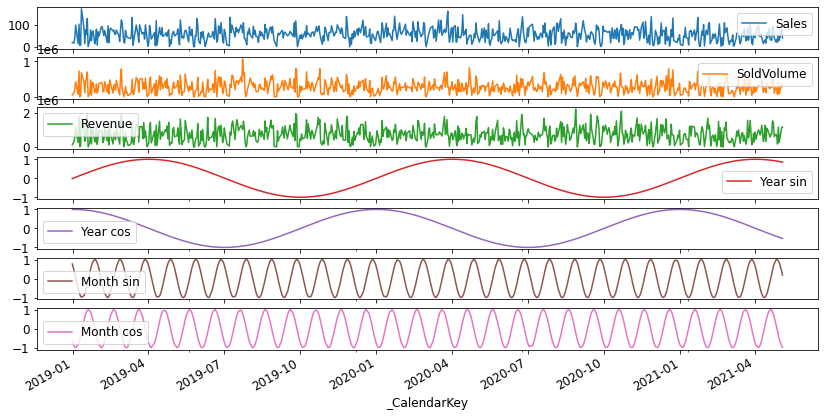

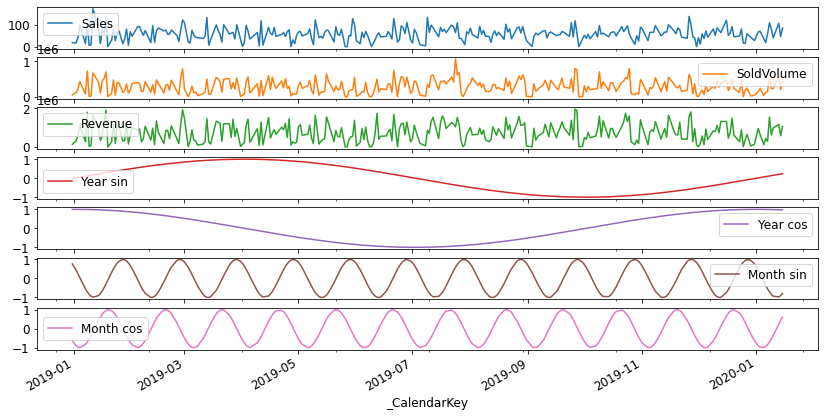

In [317]:
_ = df.plot(subplots=True)
_ = df[:290].plot(subplots=True)

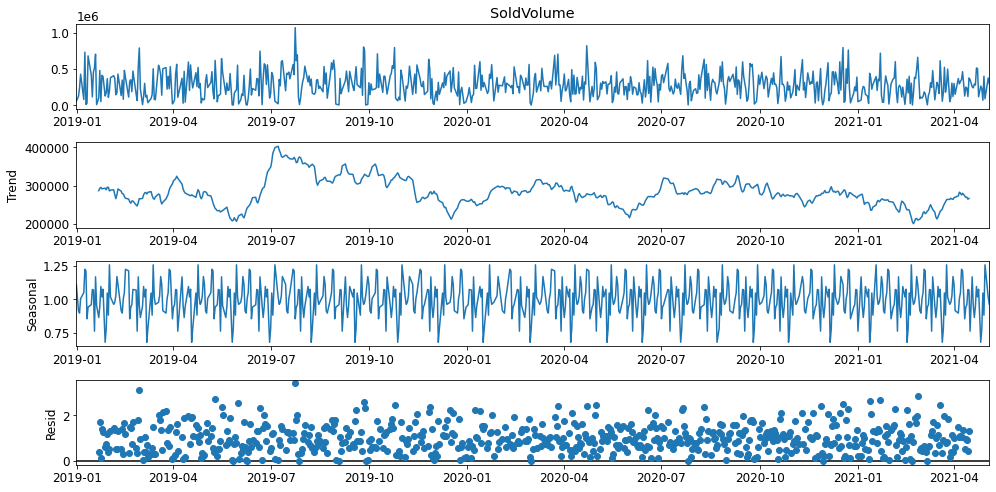

In [318]:
_ = seasonal_decompose(df["SoldVolume"], period=30, model="multiplicative").plot()

## Split the Data

In [327]:
train_index = int(len(df) * 0.7)
valid_index = int(len(df) * 0.9)

train_df = df[:train_index].copy()
valid_df = df[train_index:valid_index].copy()
test_df = df[valid_index:].copy()

In [328]:
scaler = StandardScaler()
scaler.fit(train_df)

train_df[:][:] = scaler.transform(train_df)
valid_df[:][:] = scaler.transform(valid_df)
test_df[:][:] = scaler.transform(test_df)

n_features = train_df.shape[1]

## Data Windowing

In [459]:
class WindowGenerator():
    def __init__(self, train, valid, test, input_width, label_width,
                 shift=None, label_columns=None, batch_size=32):

        # Store the raw data
        self.train_df = train
        self.valid_df = valid
        self.test_df = test

        self.batch_size = batch_size

        # Work out the label column indices
        self.label_columns = train.columns if label_columns is None else label_columns
        self.label_columns_indices = {name: i for i, name in enumerate(self.label_columns)}

        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters
        self.input_width = input_width
        self.label_width = label_width

        self.window_size = input_width + (label_width if shift is None else shift)
        self.input_slice = slice(0, input_width)

        self.input_indices = np.arange(self.window_size)[self.input_slice]
        self.input_indices_date = test.index[self.input_indices]

        self.label_start = self.window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)

        self.label_indices = np.arange(self.window_size)[self.labels_slice]
        self.label_indices_date = test.index[self.label_indices]

    def __repr__(self):
        info = [f"Total window size: {self.window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {list(self.label_columns)}\n"]

        for example_inputs, example_labels in self.train.take(1):
            info.append(f"Inputs shape (batch, time, features): {example_inputs.shape}")
            info.append(f"Labels shape (batch, time, features): {example_labels.shape}")
        return "\n".join(info)

    def split_window(self, features):
        inputs = features[:, self.input_slice,:]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]]
                               for name in self.label_columns], axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)

        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data, targets=None, sequence_length=self.window_size,
            sequence_stride=1, shuffle=True, batch_size=self.batch_size, seed=42)

        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def valid(self):
        return self.make_dataset(self.valid_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    def plot(self, col, model=None, max_subplots=3):
        total = len(self.test_df)
        splits = [i for i in range(0, total, self.window_size) if i + self.window_size < total]

        window = tf.stack([self.test_df[s : s + self.window_size] for s in splits[:max_subplots]])
        inputs, labels = self.split_window(window)

        plt.figure(figsize=(14, 3 * len(inputs)))
        plot_col_index = self.column_indices[col]

        for n in range(len(inputs)):
            plt.subplot(len(inputs), 1, n+1)
            plt.ylabel(f"{col} [normed]")

            plt.plot(self.input_indices_date, inputs[n, :, plot_col_index], 
                     label="Inputs", marker=".", zorder=-10)

            if self.label_columns is None:
                label_col_index = plot_col_index
            else:
                label_col_index = self.label_columns_indices.get(col, None)

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices_date, labels[n, :, label_col_index],
                        edgecolors="k", label="Labels", c="#2ca02c", s=64)
            
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices_date, predictions[n, :, label_col_index],
                            marker="X", edgecolors="k", label="Predictions", c="#ff7f0e", s=64)
            if n == 0:
                plt.legend()

        plt.xlabel("Time [d]")

In [460]:
multi_window = WindowGenerator(train=train_df, valid=valid_df, test=test_df,
                               label_columns=["SoldVolume"],
                               input_width=28, label_width=28, shift=28, batch_size=32)

multi_window

Total window size: 56
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Label indices: [28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55]
Label column name(s): ['SoldVolume']

Inputs shape (batch, time, features): (32, 28, 7)
Labels shape (batch, time, features): (32, 28, 1)

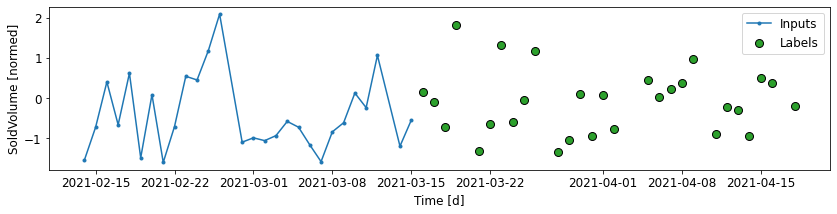

In [461]:
multi_window.plot(col="SoldVolume")

## Model

In [ ]:
def compile_and_fit(model, window, patience=10):
    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(lr=0.001)

    stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True)
    history = model.fit(window.train, epochs=10000, validation_data=window.val, callbacks=[stopping])
    return history

## Multi-Step Models